<a href="https://colab.research.google.com/github/87tana/Image-Semantic-Segmentation/blob/main/Tumor_Semantic_Segmentation_modif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting Up Environment and Importing Required Modules

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Navigate to the project directory
%cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

Mounted at /content/drive/
/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [2]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Import custom modules
from src.utils.utils import read_json, create_mask
from src.dataset.dataset import SegmentationDataset
#from src.models.resnetunet import ResNetUNet  # main model
#from src.models.resnetunet_4 import ResNetUNet_4  # model with removing 4 upsamling
#from src.models.resnet_34 import ResNet34UNet  # resenet 34, model architecture change
#from src.models.resnet_batchnorm import ResNetBatch  # batchnorm added
#from src.models.resnet_50 import ResNet50UNet
#from src.models.resnetbn2up import ResNet2up  # 2 up removed
from src.models.resnetbn2upskip import ResNet2upskip   # 2up+ skip
from src.utils.transform import deafault_transform, augmentation
from src.train import train
from src.utils.losses import DiceLoss
from src.utils.evaluation import evaluate



# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'

# Read the dataset and create a dataframe
df = read_json(root_dir)

Annotation is missing for image 1380 in train


## Defining Transformations and Creating Data Loaders

### Data Loader

In [3]:
# Create train and validation dataloaders
# Uncomment and use the train dataloader if needed

outputsize = 80

# Train dataloader
train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'train'].reset_index(drop=True), subset='train', max_samp=224,outputsize = outputsize, augment=True)

# Validation dataloader
valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'valid'].reset_index(drop=True), subset='valid', max_samp=50,outputsize = outputsize)


# Test dataloader
#valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'test'].reset_index(drop=True), subset='valid', outputsize=outputsize, max_samp=50)
#valid_loader = DataLoader(valid_dataset, batch_size=25, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
train: 100%|██████████| 224/224 [01:43<00:00,  2.17it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
valid: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=False)

## Model Setting

In [5]:
# Hyperparameters

num_epochs = 300
valid_step = 10
ckpt_step = 10
lr = 0.00002
exp_id = 'exp_19'

#resume_ckp = 'ckp_40.pt'
resume_ckp = None


# Initialize the model, loss function, and optimizer
model = ResNet2upskip()
criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss.
#criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


## Training

In [6]:
train(model,
      optimizer,
      criterion,
      num_epochs,
      train_loader,
      valid_loader,
      ckpt_step,
      valid_step,
      device,
      exp_id,
      resume_ckp = resume_ckp)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/300], Loss: 0.5938
Average Valid Loss: 0.6346
Epoch [2/300], Loss: 0.5637
Epoch [3/300], Loss: 0.5346
Epoch [4/300], Loss: 0.5069
Epoch [5/300], Loss: 0.4806
Epoch [6/300], Loss: 0.4565
Epoch [7/300], Loss: 0.4346
Epoch [8/300], Loss: 0.4146
Epoch [9/300], Loss: 0.3966
Epoch [10/300], Loss: 0.3801
Epoch [11/300], Loss: 0.3654
Average Valid Loss: 0.4011
Epoch [12/300], Loss: 0.3515
Epoch [13/300], Loss: 0.3385
Epoch [14/300], Loss: 0.3268
Epoch [15/300], Loss: 0.3158
Epoch [16/300], Loss: 0.3054
Epoch [17/300], Loss: 0.2958
Epoch [18/300], Loss: 0.2868
Epoch [19/300], Loss: 0.2783
Epoch [20/300], Loss: 0.2703
Epoch [21/300], Loss: 0.2627
Average Valid Loss: 0.2872
Epoch [22/300], Loss: 0.2554
Epoch [23/300], Loss: 0.2484
Epoch [24/300], Loss: 0.2420
Epoch [25/300], Loss: 0.2355
Epoch [26/300], Loss: 0.2292
Epoch [27/300], Loss: 0.2234
Epoch [28/300], Loss: 0.2177
Epoch [29/300], Loss: 0.2122
Epoch [30/300], Loss: 0.2069
Epoch [31/300], Loss: 0.2014
Average Valid Loss: 0.2389
Ep

In [ ]:
torch.cuda.empty_cache()

Text(0.5, 0.98, 'Training and Validation Loss Curves')

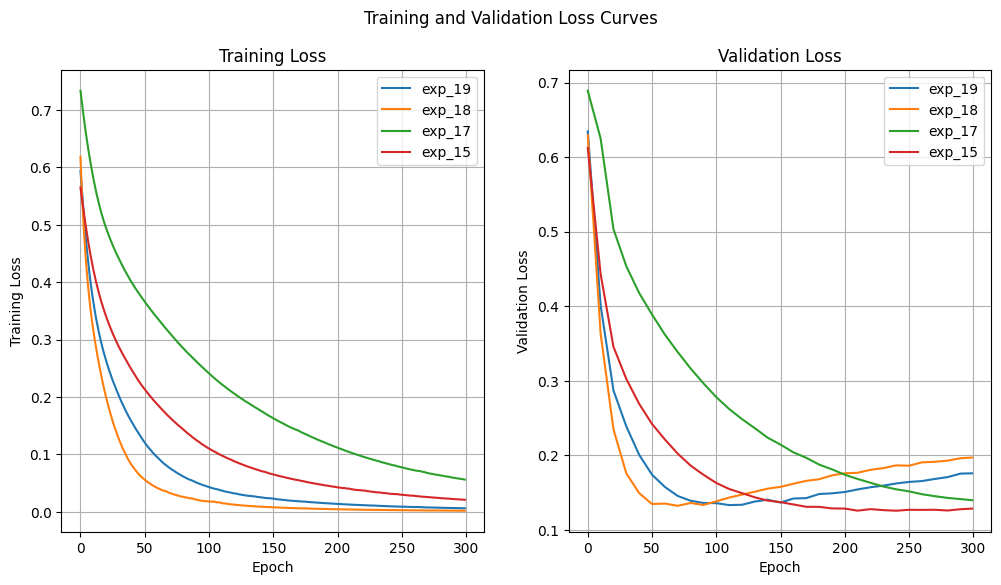

In [7]:
"""
Plot train and validation curves
"""

exp_ids = ['exp_19','exp_18', 'exp_17', 'exp_15']
xlim_ = 5
ylim_ = 0.1

fig, axes = plt.subplots (1,2,figsize=(12,6))

for exp in exp_ids:

  in_path = os.path.join('Model_Checkpoints',exp,'loss_log.npy')
  loss_log = np.load(in_path, allow_pickle=True).item()
  train_loss = loss_log['train']
  valid_loss = loss_log['valid']

  axes[0].plot(np.vstack(train_loss)[:,0],np.vstack(train_loss)[:,1]) #vertically stack the array---- (train_loss) contains elements of [epoch, epoch_loss] --> 10 0utput because we have 10.
  axes[1].plot(np.vstack(valid_loss)[:,0],np.vstack(valid_loss)[:,1])




#axes[0].set_xlim(0, xlim_)
#axes[1].set_xlim(0, xlim_)
#axes[0].set_ylim(0, ylim_)
#axes[1].set_ylim(0, ylim_)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss')
axes[0].grid(True)
axes[1].grid(True)
axes[0].legend(exp_ids)
axes[1].legend(exp_ids)

fig.suptitle('Training and Validation Loss Curves')


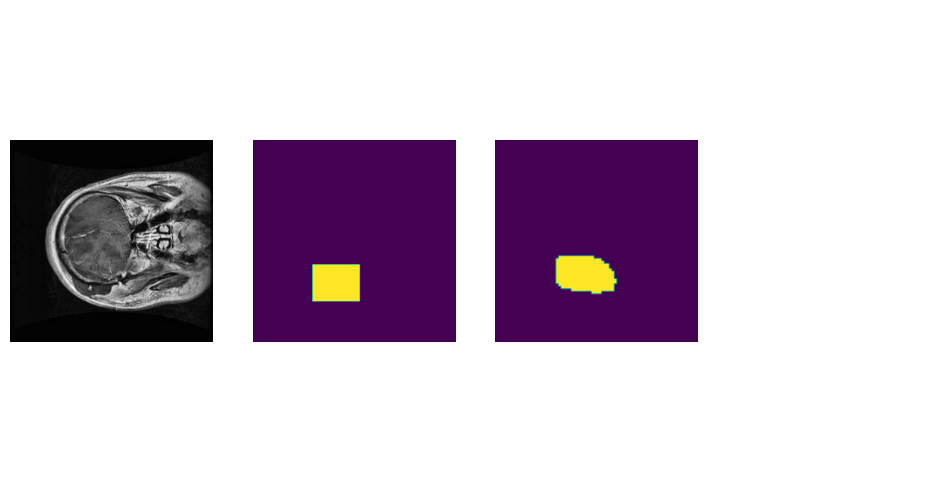

In [8]:
"""
Visualize sample validation result.
"""

#model = ResNetUNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

idx= 40

experiments = ['exp_19']
ckps = ['ckp_299.pt']


img, mask, image_o, mask_o= valid_dataset.__getitem__(idx)


model = ResNet2upskip().to(device)

img = img.unsqueeze(0)
img = img.to(device)

preds = []
iou_val = []
acc_val = []
dice_val = []
prec_val = []
rec_val = []

for i, exp in enumerate(experiments):
  # Load the trained model
  ckp_path = os.path.join('Model_Checkpoints',exp, ckps[i])
  checkpoint = torch.load(ckp_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.eval()
  sigmoid = nn.Sigmoid()  # If the model does not have embedded sigmoid


  with torch.no_grad():
    pred = model(img)
  pred = pred.squeeze(0)
  pred = pred.squeeze(0)
  pred = sigmoid(pred).cpu().numpy()

  thresh=0.2
  pred[pred>thresh]=1.0
  pred[pred<=thresh]=0.0

  preds.append(pred)


  #iou_val.append(iou(mask, pred))
  #acc_val.append(accuracy(mask, pred))
  #dice_val.append(dice_coef(mask, pred))
  #prec_val.append(precision_score_(mask, pred))
  #rec_val.append(recall_score_(mask, pred))


# Plot the image, mask, and prediction
fig, axes = plt.subplots (1,4,figsize=(12,6))


#for exp in experiments:
 # print('{s} -- IoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}\n'.format(exp,iou_val,acc_val,dice_val,prec_val,rec_val))


axes[0].imshow(image_o)
axes[1].imshow(mask_o)
axes[2].imshow(preds[0])
#axes[3].imshow(preds[1])
#axes[4].imshow(preds[2])

for i in range(4):
  axes[i].axis('off')


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model= ResNet2upskip().to(device)
# Load the trained model
ckp_path = os.path.join('Model_Checkpoints','exp_19','ckp_120.pt')

iou_val,acc_val,dice_val,prec_val,rec_val = evaluate(model, ckp_path, device, SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'valid'].reset_index(drop=True), subset='valid', outputsize = outputsize))

print('\nIoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}'.format(iou_val,acc_val,dice_val,prec_val,rec_val))


valid:  19%|█▉        | 81/429 [00:00<00:04, 84.97it/s]


Cannot read  19_jpg.rf.8e140bacd9c67bec022d7b62f31a274e.jpg


valid:  25%|██▌       | 109/429 [00:01<00:03, 86.23it/s]


Cannot read  1269_jpg.rf.9910a2b797a01f5f27e0af5c4f22316e.jpg


100%|██████████| 427/427 [00:05<00:00, 77.26it/s]


IoU:0.41, Acc:0.97, Dice:0.54, Precision:0.56, Recall:0.64


13/299-> IoU:0.34, Acc:0.97, Dice:0.44, Precision:0.58, Recall:0.45

14/299-> IoU:0.35, Acc:0.97, Dice:0.46, Precision:0.52, Recall:0.52

15/299-> IoU:0.37, Acc:0.97, Dice:0.49, Precision:0.59, Recall:0.50

16/90-> IoU:0.40, Acc:0.96, Dice:0.54, Precision:0.50, Recall:0.69


17/299 -> IoU:0.36, Acc:0.97, Dice:0.47, Precision:0.58, Recall:0.47

18/299 -> IoU:0.46, Acc:0.97, Dice:0.59, Precision:0.61, Recall:0.68

18/150 -> IoU:0.46, Acc:0.97, Dice:0.59, Precision:0.60, Recall:0.69


19/160 -> IoU:0.42, Acc:0.97, Dice:0.55, Precision:0.59, Recall:0.63





